In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

In [2]:
import tensorflow as tf
import numpy as np




In [3]:
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt

In [5]:

dataset_path = r'C:\Users\pc\OneDrive\Desktop\nit rkl\Alzheimer_s Dataset - Copy\train'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

# apply glob module to retrieve files/pathnames  

mri_path = os.path.join(dataset_path, CLASSES[1], '*')
mri_path = glob.glob(mri_path)

In [6]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=dataset_path, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [9]:

train_data, train_labels = train_data_gen.next()

 print(train_data.shape, train_labels.shape)

In [11]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


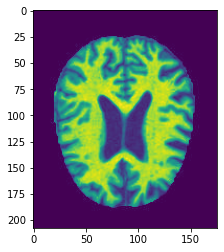

In [12]:
image = io.imread(mri_path[4])  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

In [13]:
# importing libraries
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import skimage.color as scc

C:\Users\pc\AppData\Local\Temp/ipykernel_1888/2802754522.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_image = scc.rgb2gray(image)


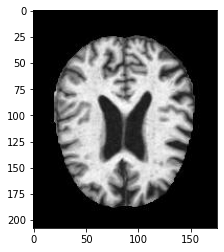

In [14]:
#normalization
gray_image = scc.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

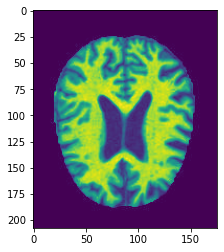

In [15]:
norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)

In [16]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

In [ ]:
# OVER SAMPLING
# - validation data
val_data, val_labels = sm.fit_resample(val_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), val_labels)

val_data = val_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(val_data.shape, val_labels.shape)

In [ ]:
# OVER SAMPLING
# - test data
test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)

test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(test_data.shape, test_labels.shape)

In [19]:
def conv_block(filters, act='relu',i=0):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_p{i}'))
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_pp{i}'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [20]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [21]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
          Input(shape=(*IMAGE_SIZE, 3)),
      
#         conv_block(32,i=1),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_p1'),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_pp1'),
        BatchNormalization(),
        MaxPool2D(),
        
#         conv_block(64,i=2),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_p2'),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_pp2'),
        BatchNormalization(),
        MaxPool2D(), 
        
#         conv_block(128,i=3),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_p3'),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_pp3'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
#         conv_block(256,i=4),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_p4'),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_pp4'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
        Flatten(),
        dense_block(128, 0.5),
        dense_block(64, 0.4),
        dense_block(32, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [27]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [25]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_p1 (Conv2D)          (None, 176, 176, 32)      896       
                                                                 
 conv2d_pp1 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_p2 (Conv2D)          (None, 88, 88, 64)        18496     
                                                                 
 conv2d_pp2 (Conv2D)         (None, 88, 88, 64)        36

In [26]:
EPOCHS = 10

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
255/255 [==============================] - 2479s 10s/step - loss: 1.4501 - acc: 0.4166 - auc: 0.6860 - f1_score: 0.4154 - val_loss: 12.9182 - val_acc: 0.2500 - val_auc: 0.5000 - val_f1_score: 0.1000
Epoch 2/10
255/255 [==============================] - 2499s 10s/step - loss: 0.9699 - acc: 0.5654 - auc: 0.8313 - f1_score: 0.5584 - val_loss: 5.3285 - val_acc: 0.2500 - val_auc: 0.5341 - val_f1_score: 0.1000
Epoch 3/10
255/255 [==============================] - 1100s 4s/step - loss: 0.7760 - acc: 0.6468 - auc: 0.8899 - f1_score: 0.6422 - val_loss: 1.3843 - val_acc: 0.3907 - val_auc: 0.6952 - val_f1_score: 0.3682
Epoch 4/10
255/255 [==============================] - 1126s 4s/step - loss: 0.6985 - acc: 0.6804 - auc: 0.9103 - f1_score: 0.6765 - val_loss: 1.3781 - val_acc: 0.4437 - val_auc: 0.7741 - val_f1_score: 0.3336
Epoch 5/10
255/255 [==============================] - 1141s 4s/step - loss: 0.6457 - acc: 0.7030 - auc: 0.9235 - f1_score: 0.6999 - val_loss: 1.0381 - val_acc: 0.510

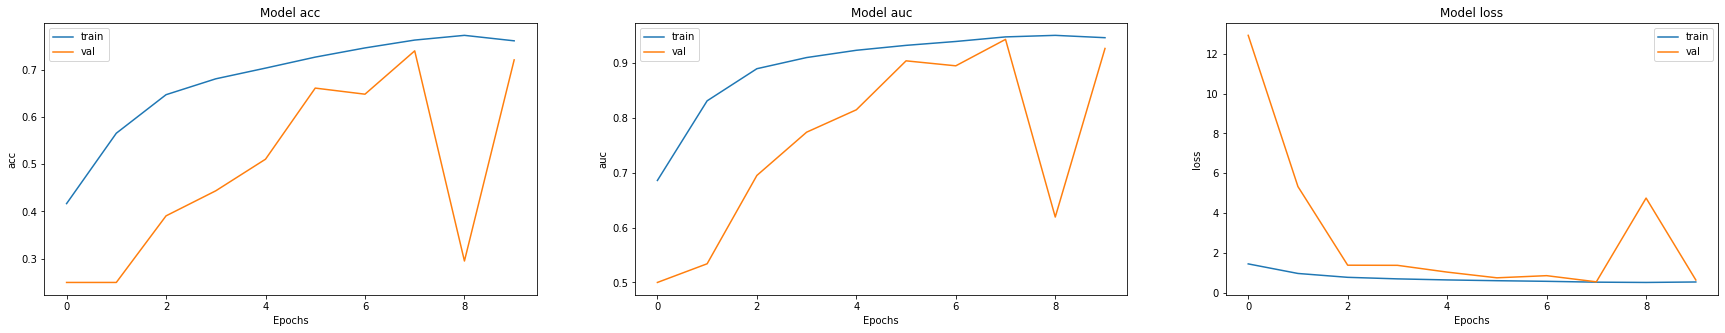

In [27]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [29]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

81/81 [==============================] - 187s 2s/step - loss: 0.6980 - acc: 0.7065 - auc: 0.9165 - f1_score: 0.7115
Training Accuracy: 79.34%
Validation Accuracy: 72.04%
Testing Accuracy: 70.65%
